## Load Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from one_hot_encoder import one_hot_encode_sex, one_hot_encode_localization, one_hot_encode_dx
from matplotlib import pyplot as plt
from transformers import ViTFeatureExtractor, ViTModel
import torch
from datasets import load_dataset
from PIL import Image

sex ['female', 'male', 'unknown']
localization ['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity']
dx ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Constants

In [2]:
N_CLASSES_PREDICTOR = 7

# [age, sex, localization]
N_DIM_AGE = 1
N_DIM_SEX = 3
N_DIM_LOCALIZATION = 15
N_DIM_IMAGE = 151296
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

## Load ViT

In [3]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
ViTmodel = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to("mps")

In [4]:
from transformers import file_utils
print(file_utils.default_cache_path)

/Users/nils_hellwig/.cache/huggingface/hub


## Create Model

In [5]:
# 1. AGE INPUT
age_input = Input((N_DIM_AGE))

# 2. SEX INPUT
sex_input = Input((N_DIM_SEX))

# 3. LOCALIZATION INPUT
localization_input = Input((N_DIM_LOCALIZATION))

# 4. IMAGE INPUT: Convolution + Flatten for the image
image_input = Input((N_DIM_IMAGE))

# Concatenate the convolutional features and the vector input
concat_layer = Concatenate()([age_input, sex_input, localization_input, image_input])
cl_layer1 = Dense(128, activation="relu")(concat_layer)
cl_layer2 = Dense(128, activation="relu")(cl_layer1)
output = Dense(N_CLASSES_PREDICTOR, activation="softmax")(cl_layer2)

# define a model with a list of two inputs
model = Model(inputs=[age_input, sex_input, localization_input, image_input], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

Metal device set to: Apple M1 Max


2022-11-15 14:39:01.942411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 14:39:01.942563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 151296)]     0           []                               
                                                                                              

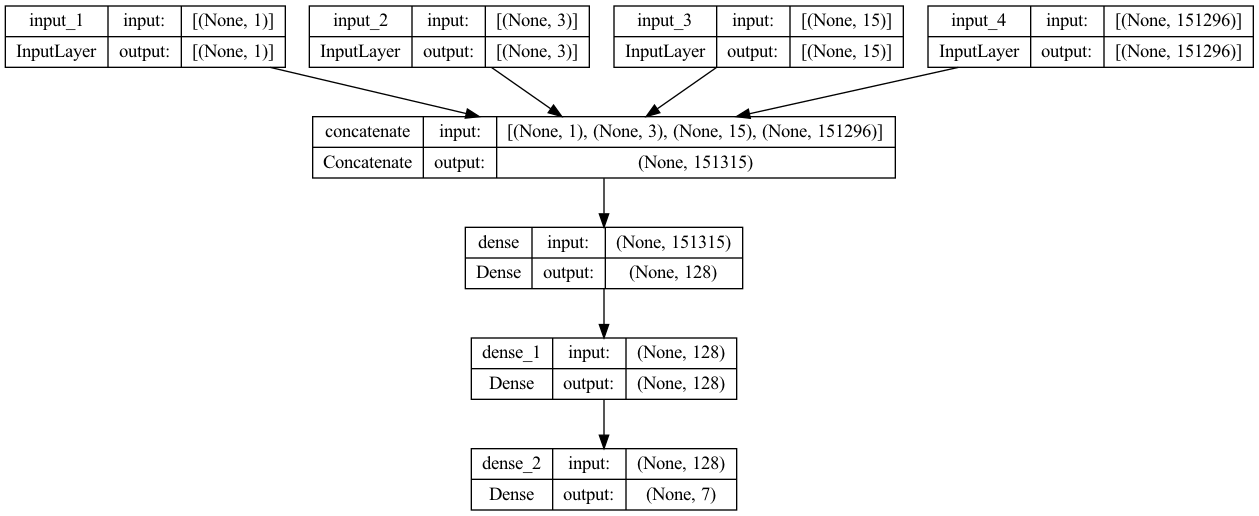

In [7]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [8]:
model.predict([np.zeros((1, N_DIM_AGE)), np.zeros((1, N_DIM_SEX)), np.zeros((1, N_DIM_LOCALIZATION)), np.zeros((1, N_DIM_IMAGE))])

1/1 [==============================] - 0s 82ms/step


2022-11-15 14:39:02.375879: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 14:39:02.420898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
        0.14285715, 0.14285715]], dtype=float32)

## Create Data Generator

In [9]:
train_df = pd.read_csv("train.csv", delimiter=";")
validation_df = pd.read_csv("validation.csv", delimiter=";")

In [10]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size, input_size, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.data_generator_size = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def add_augmentation(self, img):
        if tf.random.uniform(()) > 0.5:
            img = tf.image.flip_left_right(img)
        
        if tf.random.uniform(()) > 0.5:
            img = tf.image.random_flip_up_down(img)
            
        if tf.random.uniform(()) > 0.5:
            img = tf.keras.preprocessing.image.random_rotation(img, 0.2)
        return img
            
    def __get_image(self, image_id):
        image_arr = tf.io.read_file("dataset/"+image_id+".jpg")
        image_arr = tf.io.decode_jpeg(image_arr)
        image_arr = tf.image.resize(image_arr, [IMAGE_HEIGHT, IMAGE_WIDTH], antialias=True, method="bicubic")
        image_arr = self.add_augmentation(image_arr)

        # pass to ViT
        inputs = feature_extractor(image_arr.numpy(), return_tensors="pt")
        with torch.no_grad():
            outputs = ViTmodel(**inputs.to("mps"))
        last_hidden_states = outputs.last_hidden_state
        last_hidden_states = last_hidden_states.reshape(N_DIM_IMAGE)
        
        return last_hidden_states.cpu().data.numpy()

    def __get_input(self, image_id_batch):
        image_batch = np.array([self.__get_image(image_id) for image_id in image_id_batch]).reshape(BATCH_SIZE, N_DIM_IMAGE)
        age_batch = np.array([self.df.loc[self.df['image_id'] == image_id].age.values[0] for image_id in image_id_batch]).reshape(BATCH_SIZE, 1) / 100
        age_batch = np.nan_to_num(age_batch, copy=True, nan=0.0, posinf=None, neginf=None)
        sex_batch = np.array([one_hot_encode_sex(self.df.loc[self.df['image_id'] == image_id].sex.values[0]) for image_id in image_id_batch]).reshape(BATCH_SIZE, 3)
        localization_batch = np.array([one_hot_encode_localization(self.df.loc[self.df['image_id'] == image_id].localization.values[0]) for image_id in image_id_batch]).reshape(BATCH_SIZE, 15)

        return [age_batch,
                sex_batch, 
                localization_batch,
                image_batch]

    def __get_output(self, label, num_classes):
        return one_hot_encode_dx(label)

    def __get_data(self, batches):
        image_id_batch = batches[self.X_col]
        label_batch = batches[self.y_col]
        
        X_batch = self.__get_input(list(image_id_batch))
        y0_batch = np.asarray([self.__get_output(y, N_CLASSES_PREDICTOR) for y in label_batch])

        return X_batch, y0_batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y

    def __len__(self):
        return self.data_generator_size // self.batch_size

In [11]:
train_generator = Generator(train_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
validation_generator = Generator(validation_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

In [12]:
for bt in train_generator:
    print(bt[0][3].shape, bt[0][3].shape)
    break

(32, 151296) (32, 151296)


In [13]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True, min_delta = 0.001, verbose = 1)

In [ ]:
history = model.fit(train_generator, epochs=10, verbose=1, validation_data=validation_generator, callbacks=[early_stopping_callback])

Epoch 1/10


2022-11-15 14:39:05.678520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 2.5802 - accuracy: 0.5951

2022-11-15 14:45:09.094161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 407s 2s/step - loss: 2.5802 - accuracy: 0.5951 - val_loss: 1.2552 - val_accuracy: 0.6562
Epoch 2/10
 47/250 [====>.........................] - ETA: 4:53 - loss: 1.0608 - accuracy: 0.6842

In [ ]:
for bt in validation_generator:
    print(bt[0][3].shape, bt[0][3].shape)
    print(model.predict(bt[0]))
    break